# Proposed pipeline

## A) Loading the data

### 1. Quotebank

In [49]:
from google.colab import drive
drive.mount('/content/drive')

import bz2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
import urllib.request as ul
from collections import Counter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
pd.__version__

'1.0.5'

In [3]:
!pip install pandas==1.0.5

     |████████████████████████████████| 10.1 MB 5.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


In [3]:
def process_chunk(chunk):
        print(f'Processing chunk with {len(chunk)} rows')
        #print(chunk.columns)
    
path_to_file = '/content/drive/MyDrive/ADA/Quotebank/quotes-2020.json.bz2' 

df_test = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=1000000)
for chunk in df_test:
        process_chunk(chunk)

KeyboardInterrupt: ignored

In [14]:
# Load & format quotes from 2020
#change on everyone's computer according to personal path
path_to_file = '/content/drive/MyDrive/ADA/Quotebank/quotes-2020.json.bz2' 

list_of_quotes_dict = []
count = 0
sample_size = 10000  # Sample chosen for current experiments

# Open the 2020 quotebank
with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        if count == sample_size:
            break
        #print(instance)
        decoded = json.loads(instance.decode('utf-8'))  # Decode each instance into a dictionary
        #print(decoded["quoteID"])
        list_of_quotes_dict.append(decoded)
        count += 1

df_quotes = pd.DataFrame(list_of_quotes_dict)  # Turn list of entries into dataframe

In [30]:
df_quotes.sample(5)
df_quotes.loc[2752]

quoteID                                           2020-03-04-007103
quotation               being treated at onshore medical facilities
speaker                                               Harsh Vardhan
qids                                          [Q14647783, Q5673773]
date                                            2020-03-04 16:37:17
numOccurrences                                                    5
probas            [[Harsh Vardhan, 0.679], [None, 0.3075], [Man ...
urls              [https://www.firstpost.com/india/coronavirus-o...
phase                                                             E
Name: 2752, dtype: object

In [ ]:
def urls_to_domain(urls,domains):
  for url in urls:
    domains.append(url.split('/')[2])


In [ ]:
list_domains = []
df_quotes.loc[0:,'urls'].apply(lambda x: urls_to_domain(x,list_domains))
val = Counter(list_domains)

In [ ]:
val.most_common

<bound method Counter.most_common of Counter({'uspolitics.einnews.com': 117120, 'www.news965.com': 79756, 'www.wokv.com': 73262, 'msn.com': 67477, 'www.msn.com': 60361, 'www.breitbart.com': 52888, 'www.wsbradio.com': 45946, 'www.washingtontimes.com': 40847, 'brazilbusiness.einnews.com': 38960, 'www.nbcnews.com': 31867, 'newsok.com': 31711, 'www.krmg.com': 31524, 'www.timesofisrael.com': 28225, 'stamfordadvocate.com': 27911, 'ctpost.com': 27712, 'www.thehour.com': 27188, 'newstimes.com': 27137, 'wtmj.com': 27058, 'express.co.uk': 27042, 'www.stuff.co.nz': 26932, 'www.mirror.co.uk': 26528, 'www.nhregister.com': 26486, 'www.seattletimes.com': 26289, 'kvia.com': 25814, 'www.smh.com.au': 25739, 'www.brisbanetimes.com.au': 25711, 'sfgate.com': 24885, 'www.nbcsports.com': 24817, 'www.nytimes.com': 24116, 'timesofindia.indiatimes.com': 22994, 'www.foxnews.com': 22779, 'www.gamereactor.eu': 22461, 'www.theage.com.au': 22272, 'home.nzcity.co.nz': 21476, 'www.thesun.co.uk': 20235, 'www.bostonglob

In [ ]:
df_quotes.loc[0:4,'urls'].tolist()

[['http://israelnationalnews.com/News/News.aspx/275210'],
 ['http://thehill.com/opinion/international/478224-saudi-critics-should-revisit-sue-myricks-wake-up-america-agenda'],
 ['https://indianexpress.com/article/business/economy/cbi-to-court-gst-officials-taking-cut-from-transporters-6261429/'],
 ['https://patriotpost.us/opinion/68622-trump-budget-a-cut-above-the-rest-2020-02-15',
  'https://www.lifenews.com/2020/02/15/nancy-pelosi-and-democrats-push-bill-to-overturn-every-pro-life-law-saving-babies-from-abortions/'],
 ['https://people.com/parents/meghan-king-edmonds-not-using-frozen-embryos-with-jim-edmonds/',
  'https://people.com/parents/meghan-king-edmonds-stepkids-poisoned-false-information-about-her-jim-edmonds/',
  'https://www.usmagazine.com/celebrity-news/news/meghan-king-edmonds-says-shes-been-blocked-from-stepkids/',
  'https://people.com/tv/meghan-king-edmonds-jim-edmonds-came-with-baggage-kids/']]

### 2. Wikidata

- job title (only this for milestone 2)
- education level
- area of interest
- gender
- etc

In [6]:
# Load the speaker attributes 
wikidata = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet')

In [20]:
wikidata.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
8503394,None,[+1834-05-09T00:00:00Z],None,[Q6581097],1377540263,None,None,[Q82955],None,None,Q58196884,Angelo Pometta,None,item,None
5126565,None,[+1922-00-00T00:00:00Z],[Q36],[Q6581097],1393940864,None,None,"[Q1622272, Q1651055]",None,None,Q60148816,Piotr Okoń,None,item,None
6855,None,[+1936-03-29T00:00:00Z],[Q35],[Q6581097],1390865374,None,None,[Q82955],"[Q212101, Q507170]",None,Q131991,Mogens Camre,None,item,None
609578,None,None,[Q142],[Q6581097],1391922403,None,None,[Q82955],None,None,Q61041381,Roch Varin d'Ainvelle,None,item,None
737108,None,[+1973-06-28T00:00:00Z],None,[Q6581097],1271083690,None,None,None,None,None,Q75957010,Philip George Waller,None,item,None


#### Check how many QIDs there are per speaker:

With a sample consisting of the first 10,000 quotes of the 2020 dataset, we can read from the histogram that there is a majority of speakers who have no wikidata page (3425), and one wikidata page (4832). Then the frequency of QID number decreases rapidly (682 for two QID, 285 for three...), however there are still 9 speakers having 20 different QIDs and one speaker with 257 (whose name is *Wang Yi*, current maximum). We will need to figure out a solution for dealing with the speakers having more than one QID. 

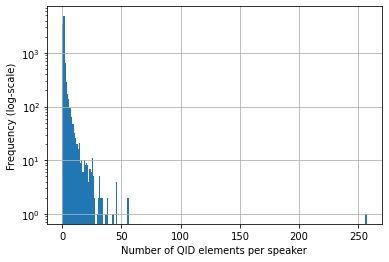

In [93]:
# Check QID list's length of every loaded quotes 
length_qids = np.zeros(len(df_quotes))
for idx, qids in enumerate(df_quotes["qids"].values):
  length_qids[idx] = len(qids)
# Plot a histogram with log-scale on Y axis
plt.hist(length_qids, bins=int(np.max(length_qids)))
plt.yscale('log')
plt.grid('on')
plt.xlabel("Number of QID elements per speaker")
plt.ylabel("Frequency (log-scale)")
#plt.xlim(0, 30) # Uncomment for focusing on a specific region 
plt.show()

In [96]:
# Display the frequency using a dataframe instead of a histogram
val, freq = np.unique(length_qids, return_counts=True)
df_QID_freq = pd.DataFrame(data={"Nb. of QID":val, "Frequency":freq})
df_QID_freq.head(5)

,Nb. of QID,Frequency
0,0.0,3425
1,1.0,4832
2,2.0,663
3,3.0,285
4,4.0,170


#### Load the human interpretable labels

In [118]:
path_to_file = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
# Directly use the built-in pandas function as the CSV is quite small 
df_labels_wiki = pd.read_csv(path_to_file,  encoding='utf-8', compression="bz2")
df_labels_wiki.head(5)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


## B) Data exploration

In [ ]:
# TODO

## C) Data preparation

### 1. Clean data according to data exploration results

#### I) Load the sentences for each speakers with >X (tbd) quotes
- Not for milestone 2, but afterwards will need info such as year, website, country and have to be able to keep them throughout the process

In [ ]:
#code here

min_quotes = 10  # Value of X

counts = df_quotes.groupby(by=["speaker"]).sum().reset_index()  # Count number of quotes per spreaker
#print(counts.head(50))
speakers_with_many_quotes = counts[counts['numOccurrences'] >= min_quotes]  # Select speakers with at least min_quotes
speakers_with_many_quotes = speakers_with_many_quotes[speakers_with_many_quotes["speaker"] != "None"]  # Remove "None" from speakers with many quotes
#print(speakers_with_many_quotes.head(50))
quotes_selected_speakers = df_quotes[df_quotes["speaker"].isin(speakers_with_many_quotes["speaker"])]  # Select quotes from speakers with many quotes
quotes_selected_speakers.head(10)

In [ ]:
quotes_selected_speakers.loc[139].quotation

### 2. Get each speaker's vocabulary

#### I) Identify compound words and join them to tokenize them together

E.g. "United States", "data science"

Information sources:
* [How to identify compound words](https://stackoverflow.com/questions/49403913/handling-compound-words-2-grams-using-nltk)
* [Sense2vec](https://explosion.ai/blog/sense2vec-with-spacy) - infeasible for us because too computationally intensive + our corpus may be too small to train sense2vec properly
* [nltk.collocations](https://www.nltk.org/howto/collocations.html) & [example usage](https://www.nltk.org/howto/collocations.html)

In [ ]:
# TODO Iris

# Identify compound words with nltk.collocations

from nltk.collocations import BigramCollocationFinder

#test_phrases = [row.quotation for _, row in quotes_selected_speakers.iterrows()]
#test_text = " ".join(test_phrases)

# note: many quotes end with a comma for some reason

#print(test_phrases)
#print(test_text)

# Format them to pass them to the MWE tokenizer

#### II) Tokenise the sentences (turn them into single words)

* [Some interesting information on tokenization](https://towardsdatascience.com/overview-of-nlp-tokenization-algorithms-c41a7d5ec4f9)
* [Multi-Word Expression tokenizer](https://www.nltk.org/_modules/nltk/tokenize/mwe.html)

In [ ]:
#your best code here
# TODO Iris: use MWE tokenizer instead of word tokenizer to avoid splitting compound words!

import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize

quotes_selected_speakers["tokenized_quote"] = quotes_selected_speakers.quotation.apply(word_tokenize)  # Tokenize quotes and add them in the dataframe as new column
quotes_selected_speakers.head()

#### \*\*\* [Test Iris, pls just ignore for now] \*\*\*

We need to find a way to reconstruct such abbreviated words like in the cell below...

In [ ]:
word_tokenize("it's, they're, can't")

##### nltk.collocations without POS tags

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

PUNCTUATION = set(string.punctuation)  # Punctuation
EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords

def format_quote_for_collocation_finder(l):
    newL = [w.lower() for w in l]  # lowercase everything
    newL = ["<P>" if w in PUNCTUATION else w for w in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = ["<S>" if w in EN_STOPWORDS else w for w in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, "<B>")  # Add begin tag
    newL.append("<E>")  # Add end tag
    return newL

marked_quotes = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder)
all_marked_quotes = [token for l in marked_quotes for token in l]

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_marked_quotes)

frequency = 4  # Minimum number of occurences of the bigram
finder.apply_freq_filter(frequency)

finder.nbest(bigram_measures.pmi, 15)  # n most collocated words
#finder.score_ngrams(bigram_measures.pmi)  # Scores

##### nltk.collocations with POS tags

In [ ]:
nltk.download('averaged_perceptron_tagger')

def format_quote_for_collocation_finder_tagged(l):
    newL = nltk.pos_tag(l)
    newL = [(w.lower(), tag) for (w, tag) in newL]  # lowercase everything
    newL = [("<P>", "TAG-P") if w in PUNCTUATION else (w, tag) for (w, tag) in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = [("<S>", "TAG-S") if w in EN_STOPWORDS else (w, tag) for (w, tag) in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, ("<B>", "TAG-B"))  # Add begin tag with random POS tag
    newL.append(("<E>", "TAG-E"))  # Add end tag with random POS tag
    return newL

marked_quotes_tagged = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder_tagged)
all_marked_quotes_tagged = [token for l in marked_quotes_tagged for token in l]

In [ ]:
finder_tagged = BigramCollocationFinder.from_words(all_marked_quotes_tagged)
frequency_tagged = 3
finder_tagged.apply_freq_filter(frequency_tagged)
finder_tagged.nbest(bigram_measures.pmi, 15)  # n most collocated words

##### Named entity recognition

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

ner_quotes = quotes_selected_speakers.tokenized_quote.apply(nltk.pos_tag)
ner_quotes = ner_quotes.apply(nltk.ne_chunk)
ner_quotes.head()

In [ ]:
print(ner_quotes[86])

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# VADER is better for short sentences, but we only have this so we use just that.

sia = SentimentIntensityAnalyzer()
#sia.polarity_scores("Hi, how are you?")
#sia.polarity_scores("Wow, NLTK is really powerful!")
sia.polarity_scores("You are a piece of shit!!")

#### III) Remove punctuation and stopwords, lowercase everything

In [ ]:
#should be easy enough, don't mess it up

nltk.download('stopwords')
from nltk.corpus import stopwords
import string

EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords
PUNCTUATION = set(string.punctuation)  # Punctuation

def lowercase(l):
    return [w.lower() for w in l]

def remove_stopwords(l):
    return [w for w in l if w.lower() not in EN_STOPWORDS]

def remove_punctuation(l):
    return [w for w in l if w not in PUNCTUATION]

def process_tokens(l):
    l = lowercase(l)  # Lowercase tokens
    l = remove_stopwords(l)   # Remove stopwords from tokens
    l = remove_punctuation(l)  # Remove punctuation from tokens
    return l

quotes_selected_speakers["tokenized_quote"] = quotes_selected_speakers.tokenized_quote.apply(process_tokens)
quotes_selected_speakers[["quotation", "tokenized_quote"]].head()

#### IV) Stem the words (ie 'eating', 'eats', 'ate' -> "eat")
* [Source](https://towardsdatascience.com/stemming-corpus-with-nltk-7a6a6d02d3e5)

In [ ]:
#go champion, you can do it!

from nltk.stem import SnowballStemmer

# You may look into other stemming algorithms than this one, but note that no stemmer will give perfect results.
SBS = SnowballStemmer(language='english')

def stem_words(l):
    return [SBS.stem(w) for w in l]

quotes_selected_speakers["tokenized_quote"] = quotes_selected_speakers.tokenized_quote.apply(stem_words)  # Stem tokens
quotes_selected_speakers[["quotation", "tokenized_quote"]].head()

#### V) Pool tokens by speaker

In [ ]:
# TODO

### 3. Assign an 'importance' score to each word

#### I) TF-IDF

In [ ]:
# TODO

#### II) Cambridge dictionary ECFR score and register

In [ ]:
def retrieve_ECFR_levels_registers(word):
  """ Functions that retrives the ECFR level of the given word as well as its register
      Input: 
        word - a string the word you want to inspect 
      Output: 
        levels - a numpy array containing strings, if empty no info was available
        registers - a list of strings, if empty no info was available
  """
  # Make a request to Cambridge dictionnary - simply add "word" to the url  
  url = 'https://dictionary.cambridge.org/dictionary/english/'+word
  # Websites don't like it when bots connect to them, so we have to pretend being a web browser! 
  req = ul.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  client = ul.urlopen(req)
  # Read and store data into htmldata 
  htmldata = client.read()
  client.close()

  # Create a beautiful soup element and parse it as an html file
  parsed_page = soup(htmldata, "html.parser")

  # A bit of backgrond:
  # In order to display the ECFR classification, the website uses <span> tags with a unique CSS class
  # The class is called "epp-xref dxref XX", where XX is any of the levels A1 to C2
  # Now we use 'bs4.find_all' to retrieve all span tag with the given class 
  # If none are returned, it means the level is not contained in the word 

  # Tag specific to the ECFR classification CSS class  
  class_name_level = "epp-xref dxref " 

  # The ECFR classification spans from A1 to C2, test for each case
  cases = np.array(["A1", "A2", "B1", "B2", "C1", "C2"])
  # We store the results in a bool vector from A1 to C2, corresponding to the level of the word  
  results = []
  for case in cases:
    # This checks how many times the case is present on page
    occurences = len(parsed_page.find_all("span", class_= class_name_level+case))
    # If the case is present more than 0 times, then the word can be classified in the given case 
    if occurences > 0:
      results.append(True)
    else: 
      results.append(False) 

  # Now let's retrieve the registers
  # We can apply the same strategy, the register of the word is contained in CSS class "usage dusage"

  class_name_register = "usage dusage"
  parsed_registers = parsed_page.find_all("span", class_=class_name_register)
  registers = []
  for register in parsed_registers:
    # Simply extract the information between the tags "span" with class class_name_register
    registers.append(register.string)

  return cases[results], registers

In [ ]:
# Add line for the word you want to look for 
levels, reg = retrieve_ECFR_levels_registers("good")
print(levels, reg)

#### III) Log2

In [ ]:
# TODO

#### IV) CEFR level of sentences

Try to implement something similar to `retrieve_ECFR_levels_registers(word)` using the web site [English Profile](http://englishprofile.org/wordlists/text-inspector) for analysing a whole sentence and get the CEFR level of each word (may be better for analysing whole quotes, and does not require stemming.)

In [ ]:
# TODO Quentin, give it a try and see how far I can go 

### 4. Create a vocabulary specific to each category in interest

#### Classify speakers into categories of interest

* Each speaker can belong to multiple categories

In [ ]:
# TODO after extracting wikidata in section A2

#### Create vocabulary

Use:
* Correlation of the use of certain words by the people in a given category
* Words used mainly by people in given category and not so much by people from other categories

Note:
* Vocabularies may overlap

Eventually:
* Weight the vocabularies

In [ ]:
#hopefully before friday 10pm 